In [1]:
import time
import numpy as np
import yaml
import autograd.numpy as np1
from scipy.optimize import Bounds
import torch
from torch import Tensor, optim
import torch.optim.lr_scheduler as lr_scheduler
from naliu import TestODEF
from neural_ode import NeuralODE
from utils import circle_points, plot_trajectories

In [2]:
from tqdm import tqdm
from hypernet import Hypernet_trans
from nnode import NNODEF
import math

In [6]:
import autograd.numpy as np
from scipy.optimize import minimize            
from scipy.optimize import BFGS
        
class Projection:
    def __init__(self, cons, bounds, dim, proj_type='euclid'):
        """
        cons: Ràng buộc (constraints)
        bounds: Giới hạn biên (bounds)
        n: Số chiều
        proj_type: Loại phép chiếu ('euclid' cho miền C hoặc 'qplus' cho miền Q+)
        """
        self.cons = cons
        self.bounds = bounds
        self.dim = dim
        self.proj_type = proj_type
        
        # Cấu hình hàm mục tiêu dựa trên loại phép chiếu
        if self.proj_type == 'qplus':
            self.objective_func = self._obj_positive_diff
        elif self.proj_type == 'euclid':
            self.objective_func = self._obj_l2_norm
        else:
            print(f"Phép chiếu {self.objective_func} không cài đặt, chọn 'qplus' hoặc 'euclid'")

    def _obj_l2_norm(self, x, y):
        """Hàm mục tiêu khoảng cách Euclid chuẩn (Dùng cho C)"""
        return np.sqrt(np.sum((x - y)**2))
    
    def _obj_positive_diff(self, x, y):
        """Hàm mục tiêu (Dùng cho Qplus)"""
        v = np.maximum(y - x, 0) 
        return np.sum(v**2)

    def project(self, target_point):
        """
        init_point: Điểm khởi tạo
        target_point: Điểm cần chiếu 
        """
        
        init_point = np.random.rand(1, self.dim).tolist()[0]
        
        res = minimize(
            self.objective_func,
            init_point,
            args=(target_point, ),
#             jac="2-point",
#             hess=BFGS(),
            constraints=self.cons,
#             method="trust-constr",
            bounds=self.bounds,
            options={'disp': False}
        )
        
        optim_point = res.x
        
        if self.proj_type == 'qplus':
            return target_point - np.maximum(target_point - optim_point, 0)
        else:
            return optim_point

In [7]:
class Problem():
    def __init__(self, f, dim_x, dim_y, proj_C, proj_Qplus):
        self.f = f
        self.dim_x = dim_x
        self.dim_y = dim_y
        self.proj_C = proj_C
        self.proj_Qplus = proj_Qplus
    
    def objective_func(self, x):
        vals = [func(x) for func in self.f]
        return np.concatenate(vals)  

# Define

In [8]:
def f1(x):
    return 4*x[0]**2 + 4*x[1]**2

def f2(x):
    return (x[0] - 5)**2 + (x[1] - 5)**2

#--------------- C --------------------#
def c1(x):
    return -(x[0] - 5)**2 - x[1]**2 + 25
def c2(x):
    return -(x[0] - 8)**2 - (x[1] + 3)**2 + 17.7


#--------------- Q --------------------#
def q1(y):
    return 50**2 - (y[0] - 50)**2 - (y[1] - 50)**2

def q_plus(y):
    center = 50.0
    radius_sq = 50**2  
    
    dx = np.maximum(0, y[0] - center)
    dy = np.maximum(0, y[1] - center)
    return radius_sq - (dx**2 + dy**2)

# Hàm dùng cho Projection 
cons_C = (
    {
        'type': 'ineq', 'fun' : c1,     
    },
    {
        'type': 'ineq', 'fun' : c2,     
    }
)

dim_x = 2
bounds_x = Bounds([-15,-15],[30, 30])

cons_Q = (
    {
        'type': 'ineq', 'fun' : q1,     
    },    
)

cons_Qplus = (
    {'type': 'ineq', 'fun': q_plus},
)
dim_y = 2

In [14]:
# Setup Projections
proj_C_handler = Projection(cons=cons_C, bounds=bounds_x, dim=dim_x, proj_type='euclid')
proj_Q_handler = Projection(cons=cons_Q, bounds=None, dim=dim_y, proj_type='qplus')

prob = Problem(
    f=[f1, f2],
    dim_x=2, dim_y=None,
    proj_C=proj_C_handler.project,
    proj_Qplus=proj_Q_handler.project
)

In [15]:
config_path='../4_Pareto_front/config.yaml'
with open(config_path, 'r') as f:
    cfg = yaml.safe_load(f)
test_rays = np.array(cfg['data']['test_ray'])
z_star = np.array([75.23575795, 25.50204271])

In [16]:
class TorchProblem:
    """
    Phiên bản PyTorch của bài toán để dùng trong Loss Function
    """
    @staticmethod
    def get_f_values(x):
        """
        Input x: Tensor shape (1, 2)
        Output: Tensor shape (1, 2) gồm [f1, f2]
        """
        # f1 = 4*x1^2 + 4*x2^2
        f1 = 4 * x[:, 0]**2 + 4 * x[:, 1]**2
        
        # f2 = (x1 - 5)^2 + (x2 - 5)^2
        f2 = (x[:, 0] - 5)**2 + (x[:, 1] - 5)**2
        
        return torch.stack([f1, f2], dim=1)

    @staticmethod
    def get_c_violation(x):
        """
        Tính mức độ vi phạm ràng buộc C (Penalty).
        Trả về 0 nếu thỏa mãn, > 0 nếu vi phạm.
        """
        # c1: -(x1 - 5)^2 - x2^2 + 25 >= 0
        val_c1 = -(x[:, 0] - 5)**2 - x[:, 1]**2 + 25
        # Vi phạm nếu val_c1 < 0 -> Penalty = ReLU(-val_c1)
        viol_c1 = torch.relu(-val_c1)

        # c2: -(x1 - 8)^2 - (x2 + 3)^2 + 17.7 >= 0
        val_c2 = -(x[:, 0] - 8)**2 - (x[:, 1] + 3)**2 + 17.7
        viol_c2 = torch.relu(-val_c2)
        
        # Có thể thêm Bounds [-15, 30] nếu cần, nhưng c1/c2 thường chặt hơn
        return viol_c1**2 + viol_c2**2

# ==========================================
# 2. HÀM SINH VECTOR R NGẪU NHIÊN
# ==========================================
def sample_one_ray(device='cpu'):
    """
    Sinh ngẫu nhiên 1 vector r trong góc phần tư thứ nhất.
    Góc theta từ 0 đến 90 độ.
    Input hypernet yêu cầu shape (1, 2)
    """
    theta = torch.rand(1) * (np.pi / 2) # Uniform [0, pi/2]
    r1 = torch.cos(theta)
    r2 = torch.sin(theta)
    r = torch.stack([r1, r2], dim=1).to(device)
    return r

In [17]:
def evaluate_objectives_torch(functions, x_tensor):
    """
    Hàm phụ trợ: Tính giá trị f1(x), f2(x) với x là Tensor.
    Vì f1, f2 viết tự nhiên, ta chỉ cần đưa Tensor vào.
    
    Args:
        functions: list các hàm [f1, f2] từ prob.f
        x_tensor: Tensor shape (2,) (đã squeeze batch dimension)
    Returns:
        Tensor shape (2,) chứa [val_f1, val_f2]
    """
    vals = []
    for func in functions:
        # func là f1 hoặc f2, nhận input x và trả về scalar tensor
        val = func(x_tensor)
        vals.append(val)
    
    # Ghép lại thành vector mục tiêu F(x)
    return torch.stack(vals)

def train_hypernet_non_constraint(hypernet, prob, z_star, num_epochs=1000, lr=1e-3):
    """
    Huấn luyện Hypernet KHÔNG quan tâm ràng buộc.
    Chỉ tối ưu hóa hàm Chebyshev.
    """
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32)
    
    print("=== TRAIN HYPERNET (NO CONSTRAINTS) ===")
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # 1. Sinh vector r ngẫu nhiên (Input 1 vector r)
        theta = torch.rand(1) * (math.pi / 2) # Góc từ 0 đến 90 độ
        r_np = np.array([math.cos(theta), math.sin(theta)])
        r_tensor = torch.tensor(r_np, dtype=torch.float32).unsqueeze(0) # Shape (1, 2)
        
        # 2. Forward Pass
        # Output x_pred có shape (1, dim_x)
        x_pred = hypernet(r_tensor)
        
        # Squeeze để đưa về vector (dim_x,) cho dễ tính toán với f1, f2
        x_vec = x_pred.squeeze(0)
        
        # 3. Tính F(x) bằng PyTorch (giữ nguyên computational graph)
        # Tận dụng prob.f chứa [f1, f2]
        y_pred = evaluate_objectives_torch(prob.f, x_vec)
        
        # 4. Tính Loss Chebyshev
        # Loss = max { r * (y - z*) }
        diff = y_pred - z_star_tensor
        weighted_diff = r_tensor.squeeze(0) * diff
        loss_obj = torch.max(weighted_diff)
        
        # 5. Backward
        loss_obj.backward()
        optimizer.step()
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}: Loss={loss_obj.item():.4f}")
            
    return hypernet


def train_hypernet(hypernet, prob, z_star, num_epochs=1000, lr=1e-3, penalty_weight=10.0):
    """
    Huấn luyện Hypernet CÓ ràng buộc trong Loss.
    Sử dụng khoảng cách đến hình chiếu làm Loss phạt.
    """
    optimizer = optim.Adam(hypernet.parameters(), lr=lr)
    z_star_tensor = torch.tensor(z_star, dtype=torch.float32)
    
    print("=== TRAIN HYPERNET (WITH CONSTRAINTS) ===")
    
    for epoch in range(num_epochs):
        hypernet.train()
        optimizer.zero_grad()
        
        # 1. Sinh vector r ngẫu nhiên
        theta = torch.rand(1) * (math.pi / 2)
        r_np = np.array([math.cos(theta), math.sin(theta)])
        r_tensor = torch.tensor(r_np, dtype=torch.float32).unsqueeze(0)
        
        # 2. Forward Pass -> x_pred (Tensor)
        x_pred = hypernet(r_tensor)
        x_vec = x_pred.squeeze(0) # Shape (2,)
        
        # 3. Tính F(x) -> y_pred (Tensor)
        y_pred = evaluate_objectives_torch(prob.f, x_vec)
        
        # 4. Tính Chebyshev Loss (Objective)
        diff = y_pred - z_star_tensor
        weighted_diff = r_tensor.squeeze(0) * diff
        loss_obj = torch.max(weighted_diff)
        
        # 5. Tính Constraint Loss (Sử dụng hàm chiếu từ Problem)
        
        # --- a. Chiếu x lên C ---
        # Cần chuyển x sang numpy để dùng scipy minimize trong proj_C
        x_np_curr = x_vec.detach().cpu().numpy()
        
        x_proj_np = prob.proj_C(x_np_curr)
        x_proj_tensor = torch.tensor(x_proj_np, dtype=torch.float32)
        
        loss_C = torch.sum((x_vec - x_proj_tensor)**2)
        
        # --- b. Chiếu y lên Q+ ---
        y_np_curr = y_pred.detach().cpu().numpy()
        
        y_proj_np = prob.proj_Qplus(y_np_curr)
        y_proj_tensor = torch.tensor(y_proj_np, dtype=torch.float32)
        
        loss_Q = torch.sum((y_pred - y_proj_tensor)**2)
        
        # 6. Tổng hợp Loss
        total_loss = loss_obj + penalty_weight * (loss_C + loss_Q)
        
        # 7. Backward
        total_loss.backward()
        optimizer.step()
        
        if epoch % 200 == 0:
            print(f"Epoch {epoch}: Total={total_loss.item():.4f} (Obj={loss_obj.item():.4f}, C={loss_C.item():.4f}, Q={loss_Q.item():.4f})")
            
    return hypernet

In [33]:
hypernet_nc = Hypernet_trans(ray_hidden_dim=32, out_dim=prob.dim_x, n_tasks=2)
hypernet_c = Hypernet_trans(ray_hidden_dim=32, out_dim=prob.dim_x, n_tasks=2)

# Train
trained_nc = train_hypernet_non_constraint(hypernet_nc, prob, z_star, num_epochs=5000)

=== TRAIN HYPERNET (NO CONSTRAINTS) ===
Epoch 0: Loss=4.9194
Epoch 200: Loss=-6.7859
Epoch 400: Loss=-11.4254
Epoch 600: Loss=-0.9996
Epoch 800: Loss=-6.7764
Epoch 1000: Loss=-10.7469
Epoch 1200: Loss=-9.4041
Epoch 1400: Loss=-10.1937
Epoch 1600: Loss=-9.8433
Epoch 1800: Loss=-10.2581
Epoch 2000: Loss=-7.9975
Epoch 2200: Loss=-0.1084
Epoch 2400: Loss=-11.4827
Epoch 2600: Loss=-10.8558
Epoch 2800: Loss=-1.2033
Epoch 3000: Loss=-10.2644
Epoch 3200: Loss=-9.8847
Epoch 3400: Loss=-1.0750
Epoch 3600: Loss=-11.6345
Epoch 3800: Loss=-11.2785
Epoch 4000: Loss=-7.7352
Epoch 4200: Loss=-7.5333
Epoch 4400: Loss=-4.6897
Epoch 4600: Loss=-10.9922
Epoch 4800: Loss=-6.7330


In [39]:
trained_c = train_hypernet(hypernet_c, prob, z_star, num_epochs=20000, penalty_weight=20.0)

=== TRAIN HYPERNET (WITH CONSTRAINTS) ===
Epoch 0: Total=333.4629 (Obj=23.4940, C=15.4984, Q=0.0000)
Epoch 200: Total=3.0383 (Obj=2.7557, C=0.0141, Q=0.0000)
Epoch 400: Total=5.0248 (Obj=3.7770, C=0.0624, Q=0.0000)
Epoch 600: Total=4.8936 (Obj=4.4278, C=0.0233, Q=0.0000)
Epoch 800: Total=2.9508 (Obj=1.8777, C=0.0537, Q=0.0000)
Epoch 1000: Total=3.6088 (Obj=3.3013, C=0.0154, Q=0.0000)
Epoch 1200: Total=3.0829 (Obj=1.6794, C=0.0702, Q=0.0000)
Epoch 1400: Total=60.9703 (Obj=0.2178, C=3.0376, Q=0.0000)
Epoch 1600: Total=11.7914 (Obj=10.1983, C=0.0797, Q=0.0000)
Epoch 1800: Total=3.8716 (Obj=3.2221, C=0.0325, Q=0.0000)
Epoch 2000: Total=3.7234 (Obj=2.9322, C=0.0396, Q=0.0000)
Epoch 2200: Total=3.4071 (Obj=2.5745, C=0.0416, Q=0.0000)
Epoch 2400: Total=3.0172 (Obj=1.8589, C=0.0579, Q=0.0000)
Epoch 2600: Total=3.1350 (Obj=1.9978, C=0.0569, Q=0.0000)
Epoch 2800: Total=1.9434 (Obj=1.1044, C=0.0420, Q=0.0000)
Epoch 3000: Total=2.9873 (Obj=2.1831, C=0.0402, Q=0.0000)
Epoch 3200: Total=3.2781 (Obj=

# Test

In [34]:
pf_true = np.load("../4_Pareto_front/tmp/pf_true.npy")
target_space = np.load("../4_Pareto_front/tmp/target_space.npy")

## Non constraint

In [37]:
hypernet_nc.eval()

pf_pred = [] 
tmp_err = [] 

t1 = time.time()


print(f"Evaluating on {len(test_rays)} rays...")

for r in test_rays:

    
    # --- Dự đoán với Hypernetwork ---
    ray_t = torch.from_numpy(r).float().unsqueeze(0)
    
    with torch.no_grad(): 
        output_x = hypernet_nc(ray_t).squeeze()

        vals = [func(output_x).item() for func in prob.f]
        
        obj_pred = np.array(vals)
    
    pf_pred.append(obj_pred)
    
#     err = np.sum(np.abs(obj_pred - y_test))
#     tmp_err.append(err)
    

t2 = time.time()

pf_pred = np.array(pf_pred)

print("-" * 30)
# print(f"Mean L1 Error: {np.mean(tmp_err):.6f}")
print(f"Inference Time: {t2-t1:.4f}s")

Evaluating on 25 rays...
------------------------------
Inference Time: 0.0109s


<Figure size 1600x800 with 0 Axes>

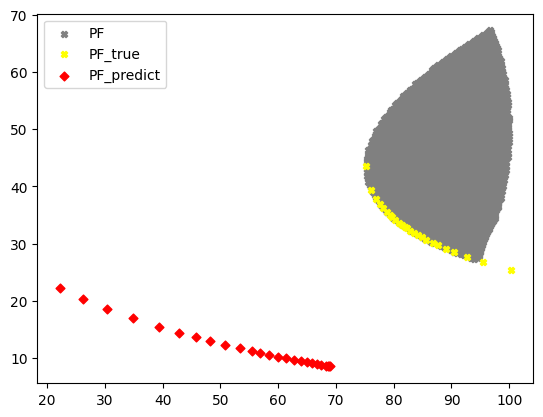

In [38]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))

## Constraint

In [40]:
hypernet_c.eval()

pf_pred = [] 
tmp_err = [] 

t1 = time.time()


print(f"Evaluating on {len(test_rays)} rays...")

for r in test_rays:

    
    # --- Dự đoán với Hypernetwork ---
    ray_t = torch.from_numpy(r).float().unsqueeze(0)
    
    with torch.no_grad(): 
        output_x = hypernet_c(ray_t).squeeze()

        vals = [func(output_x).item() for func in prob.f]
        
        obj_pred = np.array(vals)
    
    pf_pred.append(obj_pred)
    
#     err = np.sum(np.abs(obj_pred - y_test))
#     tmp_err.append(err)
    

t2 = time.time()

pf_pred = np.array(pf_pred)

print("-" * 30)
# print(f"Mean L1 Error: {np.mean(tmp_err):.6f}")
print(f"Inference Time: {t2-t1:.4f}s")

Evaluating on 25 rays...
------------------------------
Inference Time: 0.0109s


<Figure size 1600x800 with 0 Axes>

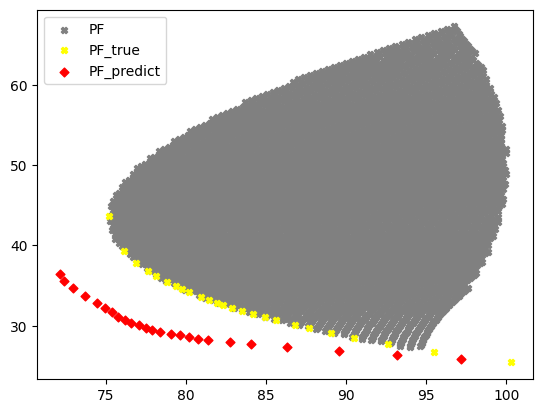

In [41]:
plot_trajectories(obs_true=np.array(pf_true),obs_predict=np.array(pf_pred),obs_pareto_front=target_space , figsize=(16, 8))